# 1 - Project setup

## 1.1 - Loading Libraries

In [1]:
# Step One: Loading Packages
# General
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import time

# For loading MNIST data in
from mlxtend.data import loadlocal_mnist

# Split Train into train, validation & testing & scoring
# Version of sklearn = 0.20.3
from sklearn.model_selection import train_test_split, validation_curve, cross_val_score, cross_validate,GridSearchCV
import sklearn.metrics as metrics

# sklearn RF ensemble library
from sklearn.ensemble import RandomForestClassifier

# sklearn support vector machine library
from sklearn import svm

# For building CNNS with PyTorch
import torch # Version 1.1.1
from torch import utils, nn
import torch.cuda as cuda
from torch.autograd import Variable
import torch.nn.functional as F

# optimisation and utilisation function for torch
import torch.optim as optim

# Skorch is scikit-learn compatible and wraps PyTorch
from skorch import NeuralNetClassifier # Version 0.5.0.post0

# sklearn preprocessing libraries for normalisation and standardisation
from sklearn.preprocessing import normalize, StandardScaler

# Seaborn to make things look 'pretty'
import seaborn as sns # Version 0.9.0

# Importing joblib for loading and dumping of models
from joblib import load,dump

## 1.2 Declaring functions for later use

In [2]:
# configuring CUDA for offloading data to GPU
def check_set_cuda():

    # Is cuda available on this machine for GPU fun?
    cuda_on = torch.cuda.is_available() 
    out = print("Is CUDA available on your machine? {}".format(torch.cuda.is_available()))

    if cuda_on == True:
        cuda.init()

        # If we're training a CNN, set the device for later CNN work
        if cuda_on == True:        
            print("You're using a : {}".format(cuda.get_device_name(0)))   
            device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    else:
        device = 'cpu'
    return(device)
        
    
def read_data():    
    # Using loadlocaL_mnist library to load local data files
    # Data can be found at: https://github.com/zalandoresearch/fashion-mnist/tree/master/data/fashion
    X_train, y_train = loadlocal_mnist(images_path='../Input/train-images-idx3-ubyte', labels_path='../Input/train-labels-idx1-ubyte')
    X_test, y_test = loadlocal_mnist(images_path='../Input/t10k-images-idx3-ubyte', labels_path='../Input/t10k-labels-idx1-ubyte')

    ## Normalise features for test & training    
    X_train = X_train.astype('float32')
    X_train = normalize(X_train)

    X_test = X_test.astype('float32')    
    X_test = normalize(X_test)
    
    return (X_train, y_train, X_test, y_test)

def generate_cm(actuals, preds):    
            
    cm = metrics.confusion_matrix(actuals, preds)

    # Generate and plot CM
    fig, ax = plt.subplots(figsize=(8,8)) 
    sns.heatmap(cm, cmap='Greens',annot=True, fmt="d", linewidths=3)    
    
    return

# 2 - Loading our previous trained Support Vector Machine Classifier - Radial Basis Function 

## 2.1 Load the data and classifier in and then generate a confusion matrix and other eval metrics

/Users/danbridgman/anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator SVC from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0.894
Training - Validation Accuracy
0.8980833333333333
Test Accuracy
0.894
Test - Recall score
0.8939999999999999
Test - Precision
0.8936726191325913
All classes
              precision    recall  f1-score   support

           0       0.82      0.86      0.84      1000
           1       0.99      0.98      0.99      1000
           2       0.81      0.80      0.81      1000
           3       0.90      0.91      0.90      1000
           4       0.80      0.82      0.81      1000
           5       0.97      0.98      0.97      1000
           6       0.74      0.70      0.72      1000
           7       0.95      0.96      0.96      1000
           8       0.98      0.98      0.98      1000
           9       0.97      0.96      0.97      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

Time: 299.97197699546814 seconds


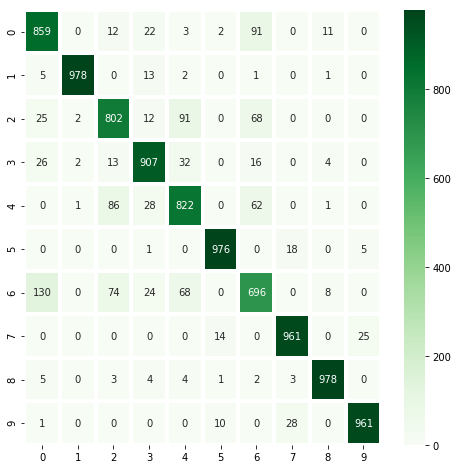

In [7]:
start_time = time.time()

# Read the data in from disk
X_train, y_train, X_test, y_test = read_data()

# Split the data into train and validate to te
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

clf = load('../Input/svc_rbf.joblib')

preds = clf.predict(X_validate)
preds_test = clf.predict(X_test)

# CROSS-VALIDATION IS ALREADY COVERED IN master Jupyter Notebook
print(metrics.accuracy_score(y_test, preds_test))

end_time = time.time()

# Using the helper function to generate a confusion matrix
generate_cm(y_test, preds_test)


print("Training - Validation Accuracy")
print(metrics.accuracy_score(y_validate, preds))

print("Test Accuracy")
print(metrics.accuracy_score(y_test, preds_test))

print("Test - Recall score")
print(metrics.recall_score(y_test, preds_test,average='macro'))

print("Test - Precision")
print(metrics.precision_score(y_test, preds_test, average='macro'))

print("All classes")
print(metrics.classification_report(y_test, preds_test))

print("Time:", end_time - start_time, "seconds")

# 3 - Convolutional Neural Network - Setup

## 3.1 Reshape data into a 4D tensor to get ready to build a CNN

In [3]:
# If we're training a CNN, set the device for later CNN work
device = check_set_cuda()
    
X_train, y_train, X_test, y_test = read_data()

X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

# Reshaping to 4D for later tensor work
X_train = X_train.reshape(-1,1,28,28)
X_test = X_test.reshape(-1,1,28,28)
X_validate = X_validate.reshape(-1,1,28,28)

y_train = torch.tensor(y_train, dtype =torch.long, device = device)
y_validate = torch.tensor(y_validate, dtype =torch.long, device = device)
y_test = torch.tensor(y_test, dtype =torch.long, device = device)

X_train.shape, y_validate.shape, y_train.shape

Is CUDA available on your machine? False


((48000, 1, 28, 28), torch.Size([12000]), torch.Size([48000]))

## 3.2 - Instantiating the CNN class, Training the CNN model, plotting Training Loss/Validation curve + other evaluation metrics

In [4]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2, stride=1)    
        self.norm1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2,2)
        self.dropout1 = nn.Dropout2d(p=0.25)
       
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2, stride=1)
        self.norm2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2,2)        
        self.dropout2 = nn.Dropout(p=0.25)        
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, padding=2, stride=1)
        self.norm3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2,2)        
        self.dropout3 = nn.Dropout(p=0.5)        
        
        self.fc1 = nn.Linear(128*3*3, 10) #- 3 Layer CNN                       
        #self.fc1 = nn.Linear(64*7*7, 10) #- 3 Layer CNN               
        
        
    def forward(self, x,**kwargs):        
        # Layer 1
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        
        # Layer 2
        x = self.conv2(x)
        x = self.norm2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.dropout2(x)
        
        # Layer 3
        x = self.conv3(x)
        x = self.norm3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        x = self.dropout3(x)                        
        
        # For debugging purposes
        #print(x.shape)
        #x = x.view(-1,7*7*64) #- 2 Layer CNN
        x = x.view(-1,128*3*3) #- 3 Layer CNN            
        #x = x.view(-1,64*7*7) #- 3 Layer CNN            
        
        x = self.fc1(x)                                            
        x = F.softmax(x, dim=-1)
        return x
    

#Load the weights in from a saved model
cnn = load('../Input/cnn.joblib')
cnn

/Users/danbridgman/anaconda3/lib/python3.7/site-packages/skorch/utils.py:481: DeviceWarning: Requested to load data to CUDA but no CUDA devices are available. Loading on device "cpu" instead.
  ), DeviceWarning)
/Users/danbridgman/anaconda3/lib/python3.7/site-packages/skorch/net.py:1506: DeviceWarning: Setting self.device = cpu since the requested device (cuda:0) is not available.
  DeviceWarning)
/Users/danbridgman/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type ConvNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=ConvNet(
    (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (dropout1): Dropout2d(p=0.25)
    (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (dropout2): Dropout(p=0.25)
    (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (norm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU()
    (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (dropout

## 3.3 - Perform predictions using pre-loaded CNN

Training - Validation Accuracy
0.9165833333333333
Test Accuracy
0.9089
Test - Recall score
0.9089
Test - Precision
0.910905724202032
All classes
              precision    recall  f1-score   support

           0       0.88      0.85      0.87      1000
           1       0.99      0.98      0.98      1000
           2       0.91      0.81      0.86      1000
           3       0.89      0.93      0.91      1000
           4       0.83      0.85      0.84      1000
           5       0.99      0.97      0.98      1000
           6       0.71      0.77      0.74      1000
           7       0.96      0.97      0.96      1000
           8       0.99      0.98      0.98      1000
           9       0.97      0.97      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



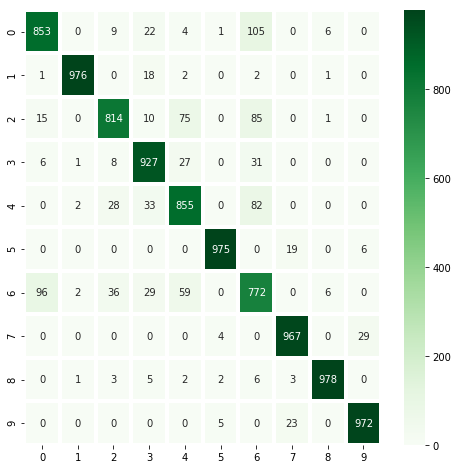

In [5]:
# Declare our empty lists for the predictions and test predictions
preds = []
preds_test = []

# Create the predictions
preds = cnn.predict(X_validate)
preds_test = cnn.predict(X_test)

# Bring the tensor back to CPU for sklearn accuracy stuff - Validation set
y_validate_cpu = y_validate.cpu()
y_validate_np = y_validate_cpu.numpy()

# Bring the tensor back to CPU for sklearn accuracy stuff - Test set
y_test_cpu = y_test.cpu()
y_test_np = y_test_cpu.numpy()

#preds_test = cross_val_predict(cnn, X_test, y_test_np, cv=5)
cm = metrics.confusion_matrix(y_test_np, preds_test)
cm_test = metrics.confusion_matrix(y_test_np, preds_test)

#print(metrics.confusion_matrix(y_test_np, preds))
print("Training - Validation Accuracy")
print(metrics.accuracy_score(y_validate_np, preds))

print("Test Accuracy")
print(metrics.accuracy_score(y_test_np, preds_test))

print("Test - Recall score")
print(metrics.recall_score(y_test_np, preds_test,average='macro'))

print("Test - Precision")
print(metrics.precision_score(y_test_np, preds_test, average='macro'))

print("All classes")
print(metrics.classification_report(y_test_np, preds_test))

# Test confusion matrix
generate_cm(y_test_np, preds_test)


# 4 - Creating RandomForest Classifiers

# 4.1 - Building a RF from a previously trained model and carry out predictions

/Users/danbridgman/anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/danbridgman/anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/danbridgman/anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/danbridgman/anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20

/Users/danbridgman/anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/danbridgman/anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/danbridgman/anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/danbridgman/anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20

/Users/danbridgman/anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/danbridgman/anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/danbridgman/anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/danbridgman/anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20

/Users/danbridgman/anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/danbridgman/anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/danbridgman/anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/danbridgman/anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20

/Users/danbridgman/anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/danbridgman/anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/danbridgman/anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/danbridgman/anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20

Prediction Time: 2.259110927581787 seconds
Training - Validation Accuracy
0.8854166666666666
Test Accuracy
0.8775
Test - Recall score
0.8774999999999998
Test - Precision
0.8768100054331643
All classes
              precision    recall  f1-score   support

           0       0.82      0.87      0.84      1000
           1       0.99      0.96      0.98      1000
           2       0.77      0.80      0.78      1000
           3       0.87      0.91      0.89      1000
           4       0.76      0.82      0.79      1000
           5       0.98      0.96      0.97      1000
           6       0.75      0.58      0.65      1000
           7       0.93      0.95      0.94      1000
           8       0.95      0.97      0.96      1000
           9       0.95      0.95      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

Prediction Time: 2.259110927581787 secon

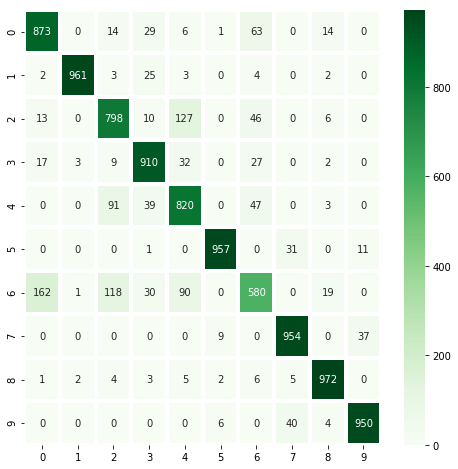

In [6]:
start_time = time.time()

# Read the data in from disk
X_train, y_train, X_test, y_test = read_data()

# Split the data into train and validate to te
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

clf = load('../Input/rf.joblib')

preds = clf.predict(X_validate)
preds_test = clf.predict(X_test)

end_time = time.time()
print("Prediction Time:", end_time - start_time, "seconds")

# CROSS-VALIDATION IS ALREADY COVERED IN master Jupyter Notebook
# Generate a CM from our helper function

generate_cm(y_test,preds_test)
print("Training - Validation Accuracy")
print(metrics.accuracy_score(y_validate, preds))

print("Test Accuracy")
print(metrics.accuracy_score(y_test, preds_test))

print("Test - Recall score")
print(metrics.recall_score(y_test, preds_test,average='macro'))

print("Test - Precision")
print(metrics.precision_score(y_test, preds_test, average='macro'))

print("All classes")
print(metrics.classification_report(y_test, preds_test))

print("Prediction Time:", end_time - start_time, "seconds")